In [1]:
from scipy import *
import numpy as np
from scipy.stats import rankdata
%matplotlib inline

In [2]:
ID, Mvir0, Vmax, Rvir, Rs, x, y, z, Spin, PID0 = load('cat/mnv_0.6_66_parents.npy').T
idx = where( (PID0==-1) & (Mvir0>=10**12))[0]
ID, Mvir, Vmax, Rvir, Rs, x, y, z, Spin, PID = load('cat/mnv_0.6_66_parents.npy')[idx,:].T
Cvir=Rvir/Rs

In [3]:
print len(PID),sum(PID==-1), sum(PID!=-1)

530696 530696 0


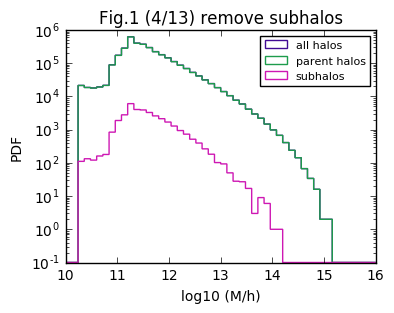

In [4]:
seed(68)
ibins=linspace(10, 16, 51)
f, ax=subplots(1,1,figsize=(4,3))
ax.hist(log10(Mvir0),bins=ibins,label='all halos', 
        histtype='step',log=1,color=rand(3))
ax.hist(log10(Mvir0[PID0==-1]),bins=ibins,label='parent halos', 
        histtype='step',log=1,color=rand(3))
ax.hist(log10(Mvir0[PID0!=-1]),bins=ibins,label='subhalos', 
        histtype='step',log=1,color=rand(3))
ax.legend(fontsize=8,loc=0)
ax.set_xlabel('log10 (M/h)')
ax.set_ylabel('PDF')
ax.set_title('Fig.1 (4/13) remove subhalos')
show()

In [24]:
logM = log10(Mvir)
Mcut=13.5
logMbins0 = percentile(logM[ (logM>=12.0) & (logM<Mcut)], linspace(0,100,101))
logMbins1 = percentile(logM[(logM>=Mcut) & (logM<15.5)], linspace(0,100,51))
logMbins = concatenate( [logMbins0, logMbins1])
print unique(logMbins0).shape, unique(logMbins1).shape

(101,) (51,)


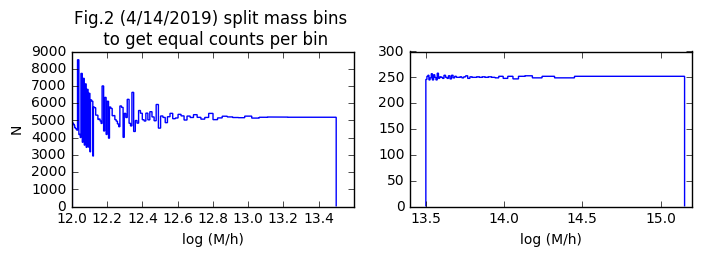

In [25]:
f, (ax1,ax2) = subplots(1,2, figsize=(8,2))
ax1.hist(logM, bins=logMbins0, histtype='step')
ax2.hist(logM, bins=logMbins1, histtype='step')
ax1.set_xlabel('log (M/h)')
ax2.set_xlabel('log (M/h)')
ax1.set_ylabel('N')
ax1.set_title('Fig.2 (4/14/2019) split mass bins \n to get equal counts per bin')
show()

In [26]:
## Cvir, Vmax, Spin
Cvir_mark = zeros(Mvir.shape)
Vmax_mark = zeros(Mvir.shape)
Spin_mark = zeros(Mvir.shape)

for i in range(len(logMbins)-1):
    iidx=where( (logM>=logMbins[i]) & (logM<logMbins[i+1]))[0]
    Cvir_mark[iidx] = rankdata(Cvir[iidx])/len(iidx)
    Vmax_mark[iidx] = rankdata(Vmax[iidx])/len(iidx)
    Spin_mark[iidx] = rankdata(Spin[iidx])/len(iidx)

In [27]:
print logM.shape, Cvir.shape, Vmax.shape, Spin.shape
print Cvir_mark.shape, Vmax_mark.shape, Spin_mark.shape

(530696,) (530696,) (530696,) (530696,)
(530696,) (530696,) (530696,)


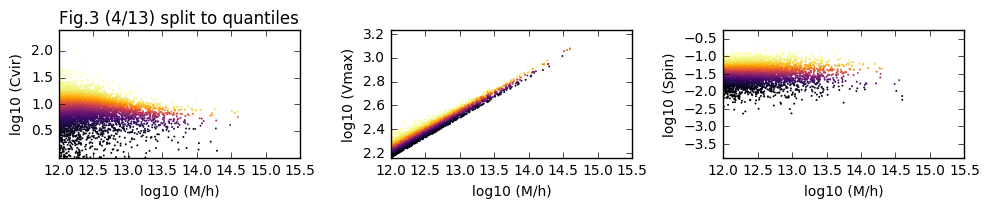

In [34]:
f, axes = subplots(1,3, figsize=(10,2))
iidx=choice(len(Cvir), len(Cvir)/100, replace=0)
for i in range(3):
    ix=log10([Cvir, Vmax, Spin][i])
    imark=[Cvir_mark, Vmax_mark, Spin_mark][i]
    axes[i].scatter(logM[iidx], ix[iidx], s=2, edgecolors='none', 
                      c=imark[iidx], cmap='inferno')
    axes[i].set_xlim(12, 15.5)
    axes[i].set_ylim(amin(ix), amax(ix))
    axes[i].set_xlabel('log10 (M/h)')
    axes[i].set_ylabel('log10 (%s)'%(['Cvir', 'Vmax', 'Spin'][i]))
plt.tight_layout()
axes[0].set_title('Fig.3 (4/13) split to quantiles')
show()